<a href="https://colab.research.google.com/github/kevincong95/cs231n-emotiw/blob/master/notebooks/2.2-la-tj-ak-kc-vl-FINAL-ensemble_baseline_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Video Sentiment Analysis in the Wild
### Ensembling Notebook | CS231n

This notebook preprocesses input videos to extract faces, frames, poses, and audio before running pre-trained models for each modality to predict group sentiment (positive, negative, or neutral). 

In [0]:
# Clone the code base
!git clone 'https://github.com/kevincong95/cs231n-emotiw.git'

# Switch to TF 1.x and navigate to the directory
%tensorflow_version 1.x
!pwd
import os
os.chdir('cs231n-emotiw')
!pwd

# Install required packages 
!pip install -r 'requirements-predictions.txt'


In [0]:
!mv ../*.zip .

#### Pose Pre-Requisites

**IMPORTANT**: Skip to the "Copy Pre-Processed Files" section if you wish to reuse existing pre-processed files

Pose extraction uses the [CMU OpenPose library](https://github.com/CMU-Perceptual-Computing-Lab/openpose) to extract body keypoints. We have pre-compiled this library for use in Colab but some system files still need to be installed. 

#### Retrieve the files

The code block below demonstrates how to retrieve the files from GCS. However, feel free to skip this step if the files are already on the local disk or you have Google Drive mounted.

In [0]:
!ls

In [0]:
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
!wget https://storage.googleapis.com/cs231n-emotiw/openpose/openpose.tar.gz
!tar -xzf openpose.tar.gz

# The pre-built OpenPose library contains shared library files that need to be manually linked
import os
orig_lib_path = os.environ['LD_LIBRARY_PATH']
os.environ["LD_LIBRARY_PATH"] = f"{orig_lib_path}:{os.getcwd()}/openpose/build/src/openpose/:{os.getcwd()}/openpose/build/caffe/lib/"

!wget https://storage.googleapis.com/cs231n-emotiw/data/train-full.zip
!wget https://storage.googleapis.com/cs231n-emotiw/data/val-full.zip
!wget https://storage.googleapis.com/cs231n-emotiw/data/test-tiny.zip
!wget https://storage.googleapis.com/cs231n-emotiw/data/Train_labels.txt
!wget https://storage.googleapis.com/cs231n-emotiw/data/Val_labels.txt


#### Preprocess Files


Here, we will instantiate each of the preprocessors and process all of the input video files.

NOTE: Change the input parameters as needed.

WARNING: This may take several hours to complete, depending on the number of files.

In general, pre-processing will extract the following:
- Video frames
- Pose keypoints
- Faces from each video frame
- Audio waveform and audio features

In [0]:
from src.preprocessors.preprocess_all_modes import preprocess
from src.preprocessors.pose_preprocessor import PosePreprocessor

print("Starting to preprocess train data")
preprocess(video_folder="train-final.zip", label_file="Train_labels.txt", local_base_path="train-tiny")

print("Starting to preprocess val data")
preprocess(video_folder="val-final.zip", label_file="Val_labels.txt", local_base_path="val-tiny")

print("Starting to preprocess test data")
preprocess(video_folder="test-tiny.zip", local_base_path="test-tiny")


In [0]:
# Remove the openpose folder as it is no longer required
!rm -rf openpose/

In [0]:
!ls

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!cp train-tiny-*.zip "/content/drive/My Drive/cs231n-project/datasets/emotiw"
!cp val-tiny-*.zip "/content/drive/My Drive/cs231n-project/datasets/emotiw"
!cp test-tiny-*.zip "/content/drive/My Drive/cs231n-project/datasets/emotiw"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Copy Pre-Processed Files
**IMPORTANT**: Run ONLY if you have NOT done the preprocessing

In [0]:
from google.colab import drive
drive.mount('/content/drive')
# TINY_PATH = 'My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw'
TINY_PATH = 'My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw'
!cp /content/drive/'$TINY_PATH'/train-final-* .
!cp /content/drive/'$TINY_PATH'/val-final-* .

!wget https://storage.googleapis.com/cs231n-emotiw/data/Train_labels.txt
!wget https://storage.googleapis.com/cs231n-emotiw/data/Val_labels.txt

In [0]:
!unzip train-final-audio.zip

In [0]:
!unzip val-final-audio
!unzip val-final-faces
!unzip val-final-frames
!unzip val-final-pose


In [0]:
!unzip -d val-final-fer val-final-fer.zip
!unzip -d train-final-fer train-final-fer.zip

Archive:  val-final-fer.zip
  inflating: val-final-fer/faces-fer-Y.npy  
  inflating: val-final-fer/faces-fer-X.npy  
Archive:  train-final-fer.zip
  inflating: train-final-fer/faces-fer-X.npy  
  inflating: train-final-fer/faces-fer-Y.npy  


In [0]:
!cp /content/drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw/train-final-audio.zip .
!cp /content/drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw/val-final-audio.zip .

In [0]:
!unzip train-final-audio
!unzip val-final-audio

In [0]:
!ls val-final-audio

audio-pickle  audio-pickle-all-X-openl3.pkl  audio-pickle-all-Y-openl3.pkl


### Run Classifiers

**IMPORTANT**: You must restart the runtime at this point to use TF 2.x

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow
print(tensorflow.__version__)

2.2.0


In [0]:
!pwd
import os
os.chdir('cs231n-emotiw')
!pwd


/content/cs231n-emotiw


FileNotFoundError: ignored

In [0]:
!git pull

In [0]:
from src.classifiers.audio_classifier import AudioClassifier
from src.classifiers.frames_classifier import FramesClassifier
from src.classifiers.pose_classifier import PoseClassifier
from src.classifiers.face_classifier import FaceClassifier

from src.classifiers.utils import get_num_samples
import numpy as np

audio_classifier = AudioClassifier('train-final-audio.zip', model_location='https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5', is_test=False)
frames_classifier = FramesClassifier('train-final-frames.zip', model_location='https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5', is_test=False)
pose_classifier = PoseClassifier('train-final-pose.zip', model_location='https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5', is_test=False)
face_classifier = FaceClassifier("train-final-fer", model_location="/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5", is_test=False)
classifiers = [audio_classifier, frames_classifier, pose_classifier , face_classifier]

sample_to_true_label = {}
with open("Train_labels.txt") as f:
    l = 0
    for line in f:
        if l == 0:
            # Skip headers
            l += 1
            continue
        line_arr = line.split(" ")
        sample_to_true_label[line_arr[0].strip()] = int(line_arr[1].strip())
        l += 1



AudioClassifier created with audio_folder = train-final-audio.zip , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
17227776/17223968 [==============================] - 1s 0us/step
FramesClassifier created with frames_folder = train-final-frames.zip , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
121389056/121384640 [==============================] - 2s 0us/step
PoseClassifier created with pose_folder = train-final-pose.zip , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
614400/612904 [==============================] - 0s 0us/step
load data
FacesClassifier created with face_folder = train-final-fer , is_test = False , model_location = /content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5


In [0]:
audio_classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 6144)]      0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          786496    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 512)         66048     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 512)         2048  

In [0]:
frames_classifier.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 12, 320, 480 0                                            
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 12, 10, 15, 2 23587712    input_15[0][0]                   
__________________________________________________________________________________________________
conv_lst_m2d_18 (ConvLSTM2D)    (None, 12, 10, 15, 1 740920      time_distributed_7[0][0]         
__________________________________________________________________________________________________
conv_lst_m2d_19 (ConvLSTM2D)    (None, 12, 10, 15, 1 740920      time_distributed_7[0][0]         
____________________________________________________________________________________________

In [0]:
pose_classifier.summary()

In [0]:
face_classifier.summary()

In [0]:
def predict(classifiers, sample_to_true_label=None, mode="soft", complex_fusion=False, weights=[]):
    assert mode in ["soft" , "hard", "weighted"]
    from collections import Counter

    classifier_outputs = []
    classifier_samples = []
    sample_to_row = {}
    num_samples = 0
    y_true = []

    for c, classifier in enumerate(classifiers):
        results, samples = classifier.predict()
        classifier_outputs.append(results.tolist())
        classifier_samples.append(list(samples))
        num_samples = len(list(samples))

    print(f"Number of samples: {num_samples}")

    for i, sample in enumerate(classifier_samples[0]):
        sample_to_row[sample] = i
        if sample_to_true_label is not None:
            y_true.append(sample_to_true_label[sample])

    X = np.zeros(shape=(len(classifiers), num_samples, 3))
    for c, output in enumerate(classifier_outputs):
        samples = classifier_samples[c]
        for i, row in enumerate(output):
            sample = samples[i]
            X[c, sample_to_row[sample], :] += row

    print(X[:, 10, :])

    if mode == "weighted":
        for c in range(X.shape[0]):
            X[c, :, :] = weights[c] * X[c, :, :]

        y_pred = np.sum(X, axis=0)
        y_pred = np.argmax(y_pred, axis=1) + 1 # Add 1 because true labels range from 1 to 3
        if sample_to_true_label is not None:
            y_true = np.array(y_true)

        print("Predicted y-labels:")
        print(y_pred)

        if sample_to_true_label is not None:
            print("True y-labels:")
            print(y_true)

            accuracy = (y_pred == y_true).mean()
            print(f"Accuracy: {accuracy}")
            return y_pred , y_true

    if mode == "soft":
        # Take the average of each 
        y_pred = np.mean(X, axis=0)
        y_pred = np.argmax(y_pred, axis=1) + 1 # Add 1 because true labels range from 1 to 3
        if sample_to_true_label is not None:
            y_true = np.array(y_true)

        print("Predicted y-labels:")
        print(y_pred)

        if sample_to_true_label is not None:
            print("True y-labels:")
            print(y_true)

            accuracy = (y_pred == y_true).mean()
            print(f"Accuracy: {accuracy}")
            return y_pred , y_true

    if mode == "hard":
        # Take the majority vote of each

        y_pred_tmp = np.zeros((len(classifier_outputs) , len(classifier_outputs[0])))

        
        for i in range(0 , X.shape[0]):
          for j in range(0 , X.shape[1]):
            y_pred_tmp[i][j] = np.argmax(X[i][j], axis=0) + 1.0
            
         
        y_pred_tmp = y_pred_tmp.T
        y_pred_tmp = np.asarray(y_pred_tmp , dtype='int64')
        
        y_pred = np.zeros((X.shape[1]))

        for i in range(0 , len(y_pred_tmp)):
          y_pred_tmp[i] = np.asarray(y_pred_tmp[i] , dtype='int64')
          counts = np.bincount(y_pred_tmp[i])
          y_pred[i] = np.argmax(counts)

        
      
   # Add 1 because true labels range from 1 to 3
        if sample_to_true_label is not None:
            y_true = np.array(y_true)

        print("Predicted y-labels:")
        print(y_pred)

        if sample_to_true_label is not None:
            print("True y-labels:")
            print(y_true)

            accuracy = (y_pred == y_true).mean()
            print(f"Accuracy: {accuracy}")
            return y_pred , y_true
    else:
        print("Not implemented yet")

    


In [0]:
face_classifier = FaceClassifier("val-final-fer", model_location="/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-final-v1/cp-0383.h5", is_test=False)

In [0]:
from src.classifiers.audio_classifier import AudioClassifier
from src.classifiers.frames_classifier import FramesClassifier
from src.classifiers.pose_classifier import PoseClassifier
from src.classifiers.utils import get_num_samples
import numpy as np

audio_classifier = AudioClassifier('val-final-audio', model_location='https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5', is_test=False)
frames_classifier = FramesClassifier('val-final-frames', model_location='https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5', is_test=False)
pose_classifier = PoseClassifier('val-final-pose', model_location='https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5', is_test=False)
face_classifier = FaceClassifier("val-final-fer", model_location="/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5", is_test=False)
classifiers = [audio_classifier, frames_classifier, pose_classifier, face_classifier] 
#classifiers = [face_classifier] 
#classifiers = [audio_classifier, frames_classifier, pose_classifier] 
# Audio Classifier = 0.57
# Frames classifier = 0.56
# Pose classifier = 0.48

sample_to_true_label = {}
with open("Val_labels.txt") as f:
    l = 0
    for line in f:
        if l == 0:
            # Skip headers
            l += 1
            continue
        line_arr = line.split(" ")
        sample_to_true_label[line_arr[0].strip()] = int(line_arr[1].strip())
        l += 1
print(sample_to_true_label)


## Weighted Voting Results

In [0]:
y_pred_weighted , y_true = predict(classifiers, sample_to_true_label, mode="weighted", weights=[0.4 , 0.5 , 0.07 , 0.03]) #0.4, 0.5, 0.07 , 0.03


In [0]:
from sklearn.metrics import classification_report
target_names = ["Positive" , "Neutral" , "Negative"]

## Classification Report -- Weighted Voting

In [0]:
print(classification_report(y_true, y_pred_weighted, target_names=target_names , digits=3))

              precision    recall  f1-score   support

    Positive      0.728     0.417     0.531       302
     Neutral      0.541     0.771     0.636       280
    Negative      0.613     0.647     0.630       184

    accuracy                          0.602       766
   macro avg      0.628     0.612     0.599       766
weighted avg      0.632     0.602     0.593       766



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


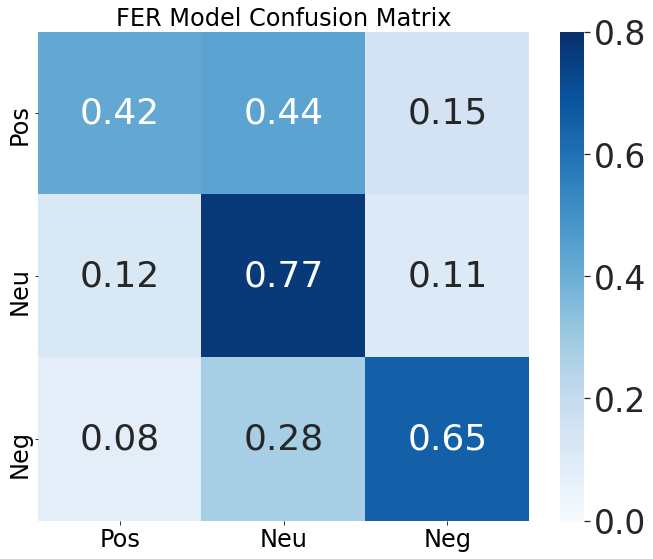

In [0]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
classes=['Pos' , 'Neu' , 'Neg'] 
con_mat = tf.math.confusion_matrix(labels=y_true-1, predictions=y_pred_weighted-1).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
figure = plt.figure(figsize=(11, 9))
plt.tick_params(labelsize=24)
plt.title("Weighted Model Confusion Matrix", fontsize=24)
sn.set(font_scale=3.0)
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues , vmin=0 , vmax=0.8)

## Soft Voting Results

In [0]:
y_pred_soft , y_true = predict(classifiers, sample_to_true_label)

Skipping unzipping files as input is a folder
Skipping unzipping files as input is a folder
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 7
Skipping unzipping files as input is a folder
['2', '1', '3']
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 7


/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Number of samples: 766
[[0.08749045 0.20644732 0.7060622 ]
 [0.04470335 0.03653668 0.91875994]
 [0.17676936 0.17970438 0.64352626]
 [0.25732085 0.34432521 0.3983539 ]]
Predicted y-labels:
[3 2 2 3 2 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 3 1 2 1 1 2 2 1 3 3 1 1 1 1 2 2 3 3 2 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 1 1 1 3 1 1 3 3 3 3 2 3 3 2 2 2 2
 3 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1
 3 3 1 1 2 1 3 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 3 3 3 3 2 2 2 2 2 3 2 2 1
 2 3 2 3 1 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2
 2 2 2 3 3 3 3 3 2 3 3 2 2 3 3 3 3 3 2 2 2 3 1 1 3 2 3 3 3 3 2 3 3 2 2 2 2
 2 1 2 2 3 1 2 3 2 2 2 3 3 2 2 2 2 2 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 2 1 1 3 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 3 3 3 3 3

## Classification Report -- Soft Voting


In [0]:
print(classification_report(y_true, y_pred_soft, target_names=target_names, digits=3))

              precision    recall  f1-score   support

    Positive      0.764     0.397     0.523       302
     Neutral      0.551     0.793     0.650       280
    Negative      0.646     0.723     0.682       184

    accuracy                          0.620       766
   macro avg      0.654     0.638     0.618       766
weighted avg      0.658     0.620     0.608       766



## Confusion Matrix -- Soft Voting

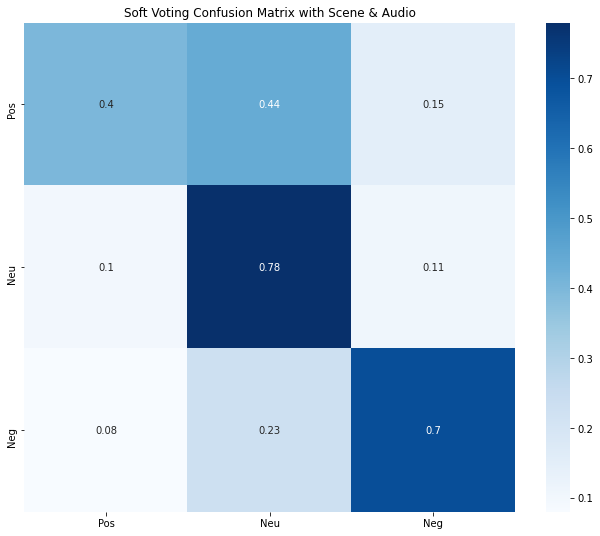

In [0]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
cm=metrics.confusion_matrix(y_true,y_pred_soft)
import matplotlib.pyplot as plt
import tensorflow


classes=['Pos' , 'Neu' , 'Neg'] 

y_pred_final , y_true_final = y_pred_soft - 1 , y_true - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)


figure = plt.figure(figsize=(11, 9))
plt.title("Soft Voting Confusion Matrix with Scene & Audio")
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)

## Hard Voting Results

In [0]:
y_pred_hard , y_true = predict(classifiers, sample_to_true_label , mode="hard")

Skipping unzipping files as input is a folder
Skipping unzipping files as input is a folder
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 7
Skipping unzipping files as input is a folder
['2', '1', '3']
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 7


/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Number of samples: 766
[[0.08749045 0.20644732 0.7060622 ]
 [0.04470335 0.03653668 0.91875994]
 [0.17676936 0.17970438 0.64352626]
 [0.25732085 0.34432521 0.3983539 ]]
Predicted y-labels:
[3. 1. 2. 2. 2. 2. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 3. 2. 1. 2. 2. 2. 2. 1. 3. 3.
 1. 1. 1. 1. 2. 2. 3. 3. 2. 3. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 1. 2. 1.
 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 1. 1. 1. 3. 1. 1.
 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 3. 2. 2. 2. 2. 3. 3. 2. 3.
 3. 3. 3. 3. 3. 3. 1. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 3. 2. 3. 3. 1. 1. 3. 2. 3. 2. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 3. 3. 3. 2. 1. 2. 2. 2. 2. 3. 2. 1. 1. 2. 1. 2. 3. 1. 3. 1.
 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2.
 2. 2. 2. 2. 3. 2. 2. 2. 2. 3. 3. 3. 3. 3. 2. 3. 3. 2. 2. 3. 3. 3. 3. 3.
 1. 2. 3. 2. 2. 1. 3. 1. 3. 3. 3. 3. 2. 3. 3. 1. 1. 3. 2. 2. 1. 1. 1. 2.
 1. 1. 3.

In [0]:
print(classification_report(y_true, y_pred_hard, target_names=target_names, digits=3))

              precision    recall  f1-score   support

    Positive      0.672     0.440     0.532       302
     Neutral      0.514     0.736     0.605       280
    Negative      0.635     0.576     0.604       184

    accuracy                          0.581       766
   macro avg      0.607     0.584     0.580       766
weighted avg      0.605     0.581     0.576       766



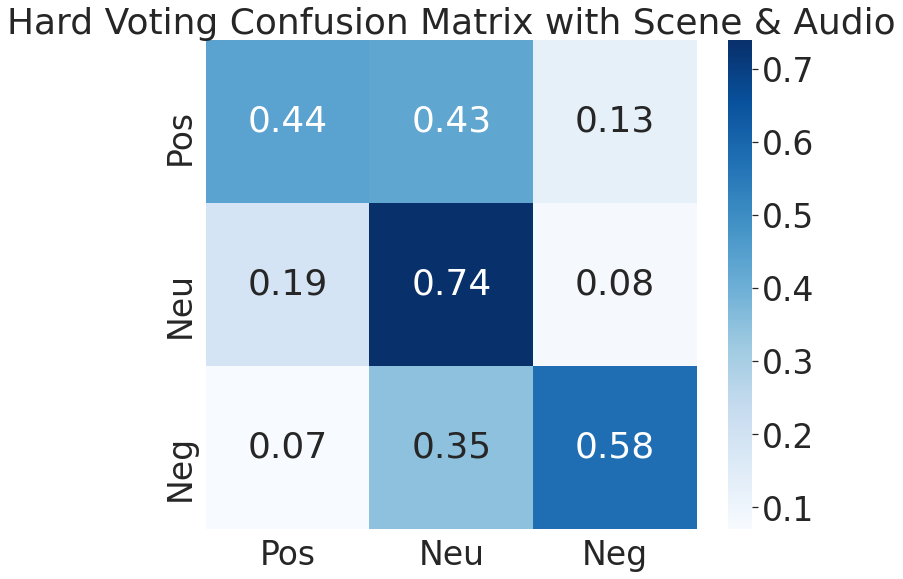

In [0]:
y_pred_final , y_true_final = y_pred_hard - 1 , y_true - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)


figure = plt.figure(figsize=(11, 9))
plt.title("Hard Voting Confusion Matrix with Scene & Audio")
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)

